In [1]:
import warnings
from os.path import join, isdir
from os import mkdir
from typing import Union
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda

from utils import worst_subgroup_accuracy

from config import get_config
from datasets import BiasSubset
from datasets.utils import BalancedSampler
from models.utils import extract_features
from shortcut_removal.dfr import DeepFeatureReweighting
from shortcut_removal.dfr import CustomLogisticRegression

In [ ]:
# NOTE: Cell tagged as 'parameters' to allow for execution with
# papermill/nbconvert.

# Reproducibility.
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# General settings.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "./data/"

# Matplotlib settings.
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
mpl.rc('text', usetex=True)

# Visualization settings.
# The colors are taken from tab20.
colors = {
    "ERM": ("#1f77b4", "#aec7e8", "--"),
    "DFR": ("#ff7f0e", "#ffbb78", ":"),
    "EvA": ("#E377C2", "#F7B6D2", "-."),
    "AMSEL (Ours)": ("#2CA02C", "#98DF8A", "-"),
}

# Experiment-specific settings.
regularization_parameters_c = [70_000, 30_000, 10_000, 7_000, 3_000, 1_000., 700., 300., 100., 70., 30., 10., 7., 3., 1., 0.7, 0.3, 0.1, 0.07, 0.03, 0.01, 0.007, 0.003, 0.001]
balancing_factor_step = 0.05
balancing_factor_mode = "default" # 'default' vs. 'min_max'
score_mapping = "linear_regression"
score_function_name = "Consensus"
if "dataset_name" not in globals():
    dataset_names = ["celeba", "chestx-ray14"]
    dataset_name = dataset_names[0]

In [3]:
def display_df(df):
    # Introduces automatic line-breaks.
    styler = df.style.set_table_styles([dict(selector="th",props=[('max-width', '120px'), ("word-break", "break-all")])])
    display(HTML(styler.to_html()))

# Hyperparameter Tuning for DFR / AMSEL Classifiers

This notebook details the process of selecting the optimal inverse regularization strength, $C$, for the logistic regression classifiers used in our method. This is a necessary prerequisite for the main experiments.

### Methodology
To ensure a fair comparison and robust results, we follow the hyperparameter selection procedure from Kirichenko et al. (DFR). The core idea is to select the hyperparameter that maximizes worst-group performance.

The process is as follows:
1.  **Data Splitting:** We use the same validation data split as in the main experiment:
    *   $\mathcal{D}_{\mathrm{candidate}}$ (`subset_train_dfr`): Used to **train** the classifier heads.
    *   $\mathcal{D}_{\mathrm{mapping}}$ (`subset_train_score_mapping`): Used as a held-out **validation set** to evaluate the trained heads and select the best `C`.
2.  **Model Training:** For a range of candidate values for $C$, we train classifier heads on a **fully balanced** version of $\mathcal{D}_{\mathrm{candidate}}$ (i.e., with balancing parameter $\theta=1.0$). This setup is equivalent to the standard DFR method.
3.  **Evaluation and Selection:** We evaluate each trained model on the validation set $\mathcal{D}_{\mathrm{mapping}}$. The value of $C$ that yields the highest **worst-group accuracy** is chosen as the optimal hyperparameter.

## 1. Setup and Preliminaries

This section covers the initial setup, which mirrors the main experiment notebook. We load configurations, prepare data splits, and define subgroups.

### 1.1. Configuration and Parameters

We begin by loading the dataset-specific configuration and defining the set of balancing parameters $\theta$ that will be used to construct the candidate models and simulate different test distributions.

In [4]:
print(f"Evaluating AMSEL for the following dataset: {dataset_name}")
print(f"Evaluating the following inverse regularization strengths: {regularization_parameters_c}")

# Load config.
dataset_config = get_config(dataset_name, root_dir=root_dir)

# Prepare output folder.
output_dir = join(".", "outputs", dataset_name)
if not isdir(output_dir):
    print(f"Creating output directory: {output_dir}")
    mkdir(output_dir)

# Extract parameters.
balancing_factor_min = dataset_config.balancing_factor_min
balancing_factor_max = dataset_config.balancing_factor_max

Evaluating AMSEL for the following dataset: celeba
Evaluating the following inverse regularization strengths: [70000, 30000, 10000, 7000, 3000, 1000.0, 700.0, 300.0, 100.0, 70.0, 30.0, 10.0, 7.0, 3.0, 1.0, 0.7, 0.3, 0.1, 0.07, 0.03, 0.01, 0.007, 0.003, 0.001]


In [5]:
if balancing_factor_mode == "min_max":
    # Calculate the smallest multiple of step >= minimum.
    start = np.ceil(balancing_factor_min / balancing_factor_step) * balancing_factor_step

    # Calculate the largest multiple of step <= maximum.
    end = np.floor(balancing_factor_max / balancing_factor_step) * balancing_factor_step

    # Generate balancing factors.
    balancing_factors = np.arange(start, end + balancing_factor_step / 2, balancing_factor_step)
elif balancing_factor_mode == "default":
    balancing_factors = np.round(np.linspace(0, 1., 21), 2) # Round due some numbers like 0.6 becoming 0.6.....1 (precision errors)
    balancing_factor_min, balancing_factor_max = 0, 1
else:
    raise ValueError("Invalid balancing factor creation mode specified!")

assert 0 in balancing_factors and 1 in balancing_factors, "Make sure that you balancing factors contain both theta=0 and theta=1."
unbiased_model_idx = np.where(balancing_factors == 1.0)[0][0]
print("Evaluating balancing factors:", balancing_factors)

Evaluating balancing factors: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [6]:
def balancing_factor_to_index(balancing_factor: float, clip: bool = False) -> Union[float, int]:
    # While we could cast the index to int because indices have to be integers,
    # we explicitly choose to leave this to the user to ensure invertability.
    # [min, max] -> [0,1].
    balancing_factor = (balancing_factor - np.min(balancing_factors)) / (np.max(balancing_factors) - np.min(balancing_factors))

    # [0,1] -> [0, len(balancing_factors) - 1].
    balancing_factor_idx = balancing_factor * (len(balancing_factors) - 1)

    if clip:
         balancing_factor_idx = np.clip(balancing_factor_idx, a_min=0, a_max=len(balancing_factors) - 1)

    return balancing_factor_idx

def index_to_balancing_factor(balancing_factor_idx: int, clip: bool = False) -> float:
    # [0, len(balancing_factors) - 1] -> [0,1].
    balancing_factor = balancing_factor_idx / (len(balancing_factors) - 1)

    # [0,1] -> [min, max].
    balancing_factor = balancing_factor * (np.max(balancing_factors) - np.min(balancing_factors)) + np.min(balancing_factors)
    
    if clip:
        balancing_factor = np.clip(balancing_factor, a_min=np.min(balancing_factors), a_max=np.max(balancing_factors))
                                   
    return balancing_factor

### 1.2. Data Loading and Preparation

We load the validation dataset and split it into two disjoint halves. This setup is identical to the main experiment, but the roles of the splits are adapted for hyperparameter tuning.
-   `subset_train_dfr` ($\mathcal{D}_{\mathrm{candidate}}$): The **training set** for the classifier heads.
-   `subset_train_score_mapping` ($\mathcal{D}_{\mathrm{mapping}}$): The held-out **validation set** for selecting the best `C`.

In [7]:
dataset_val, dataset_test = dataset_config.get_datasets()

In [8]:
# Note that we have to shuffle the indices because the validation dataset might
# be sorted. However, because we pass a seed, the shuffling is fully
# reproducible.
indices = list(range(len(dataset_val)))
random_generator = np.random.default_rng(seed)
random_generator.shuffle(indices)
subset_train_dfr = BiasSubset(dataset_val, indices=indices[:len(indices)//2])
subset_train_score_mapping = BiasSubset(dataset_val, indices=indices[len(indices)//2:])
subset_test = dataset_test

print("#Samples Train DFR:\t\t", len(subset_train_dfr))
print("#Samples Train Score Mapping:\t", len(subset_train_score_mapping))
print("#Samples Test:\t\t\t", len(subset_test))

#Samples Train DFR:		 9933
#Samples Train Score Mapping:	 9934
#Samples Test:			 19962


In [9]:
# Extract labels.
labels_train_dfr = np.array([subset_train_dfr.label(idx) for idx in range(len(subset_train_dfr))])
labels_train_score_mapping = np.array([subset_train_score_mapping.label(idx) for idx in range(len(subset_train_score_mapping))])
labels_test = np.array([subset_test.label(idx) for idx in range(len(subset_test))])

In [10]:
# Create dataloader.
dataloader_train_dfr = DataLoader(
    subset_train_dfr,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
)
dataloader_train_score_mapping = DataLoader(
    subset_train_score_mapping,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
)
dataloader_test = DataLoader(
    subset_test,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
)

### 1.3. Model and Feature Extractor

We load a standard ERM model pre-trained on the biased training set $\mathcal{D}$.
The feature extractor $e$ of this model will be fixed and used to generate feature representations for all subsequent steps.
We consider multiple ERM models (trained with different seeds) to report mean and standard deviation over our results.

In [11]:
Model = dataset_config.ModelClass
base_models = dataset_config.get_base_models()
print(f"Considering the following base models: {base_models}")

Considering the following base models: ['izmailov_resnet50_erm_seed1', 'izmailov_resnet50_erm_seed2', 'izmailov_resnet50_erm_seed3', 'izmailov_resnet50_erm_seed4', 'izmailov_resnet50_erm_seed5']


### 1.4. Subgroup Identification

As defined in the paper, we formalize bias as an imbalance between subgroups $\mathcal{G}$, where each subgroup is a combination of a class label and a bias attribute. We identify these subgroups for each data split, as the subgroup labels are required for creating the re-weighted datasets $\mathcal{D}_\theta$.


In [12]:
SubgroupIdentifier = dataset_config.SubgroupIdentifierClass
print(f"Using the following subgroup identification method: {SubgroupIdentifier}")

Using the following subgroup identification method: <class 'subgroup_identification.ground_truth.GTSubgroups'>


In [13]:
subgroup_identifier = SubgroupIdentifier()
group_ids_train_dfr, n_subgroups = subgroup_identifier.identify_subgroups(None, subset_train_dfr, device)
group_ids_train_score_mapping, _ = subgroup_identifier.identify_subgroups(None, subset_train_score_mapping, device)
group_ids_test, _ = subgroup_identifier.identify_subgroups(None, subset_test, device)
group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test = [z.cpu().detach().numpy() for z in (group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test)]

# Remove empty groups if desired (i.e., re-ordering such that empty groups are
# listed last and then discarding them).
if dataset_config.subgroup_postprocessor:
    n_subgroups, group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test = dataset_config.subgroup_postprocessor(group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test)

# Are the subgroups balanced?
print("Number of subgroups: ", n_subgroups)
print("Subgroup balancing (train DFR):", np.unique(group_ids_train_dfr, return_counts=True)[1])
print("Subgroup balancing (train score mapping):", np.unique(group_ids_train_score_mapping, return_counts=True)[1])
print("Subgroup balancing (test subset):", np.unique(group_ids_test, return_counts=True)[1])

# Test for missing subgroups.
# We expect that each subset contains all subgroups when performing the balanced
# subsampling. Alternatively, one could adapt the BalancedSampler such that it
# allows subgroups not to be present.
assert len(set(group_ids_train_dfr)) == n_subgroups, "No samples of the following subgroup(s) in subset_train_dfr: " + str(set(range(n_subgroups)).difference(set(group_ids_train_dfr))) 
assert len(set(group_ids_train_score_mapping)) == n_subgroups, "No samples of the following subgroup(s) in subset_train_score_mapping: " + str(set(range(n_subgroups)).difference(set(group_ids_train_score_mapping)))
assert len(set(group_ids_test)) == n_subgroups, "No samples of the following subgroup(s) in subset_test: " + str(set(range(n_subgroups)).difference(set(group_ids_test))) 

Extract subgroup ids: 100%|██████████| 19962/19962 [00:00<00:00, 124104.08it/s]

Number of subgroups:  4
Subgroup balancing (train DFR): [4294 4060 1479  100]
Subgroup balancing (train score mapping): [4241 4216 1395   82]
Subgroup balancing (test subset): [9767 7535 2480  180]


### 1.5. Simulating Test Distributions with Varying Bias

To evaluate the robustness of our method, we simulate a range of test distributions with varying degrees of spurious correlation. We achieve this by re-sampling the validation and test sets according to the parameterized distribution $P_\theta(Y, B) = \theta \, P_{\mathrm{bal}}(Y,B) + (1-\theta) \, P_{\mathrm{orig}}(Y,B)$, where $\theta=0$ corresponds to the original biased distribution and $\theta=1$ corresponds to a perfectly balanced one. The `BalancedSampler` generates subsets of indices that approximate these target distributions.

In [14]:
# Generate dataset subsamples with the desired balancing factors.
# Note that since we set the seed, all models are evaluated on the 
# same subsets (per balancing factor).
balancing_mode = "exact_under"
subset_indices_per_balancing_factor_train_dfr = [
    list(
        BalancedSampler(
            subset_train_dfr,
            mode=balancing_mode,
            balancing_factor=balancing_factor,
            labels=torch.tensor(group_ids_train_dfr),
            seed=seed
        )
    )
    for balancing_factor in balancing_factors
]

subset_indices_per_balancing_factor_train_score_mapping = [
    list(
        BalancedSampler(
            subset_train_score_mapping,
            mode=balancing_mode,
            balancing_factor=balancing_factor,
            labels=torch.tensor(group_ids_train_score_mapping),
            seed=seed
        )
    )
    for balancing_factor in balancing_factors
]

subset_indices_per_balancing_factor_test = [
    list(
        BalancedSampler(
            subset_test,
            mode=balancing_mode,
            balancing_factor=balancing_factor,
            labels=torch.tensor(group_ids_test),
            seed=seed
        )
    )
    for balancing_factor in balancing_factors
]

The plot below visualizes the effect of the balancing parameter $\theta$ on the subgroup composition of the resulting test subsets. As $\theta$ increases from 0 to 1, the proportions of all subgroups converge to be uniform, effectively removing the spurious correlation.

x-intercept for subgroup 1: 2.047472266076132
x-intercept for subgroup 2: 2.9624657537231305
x-intercept for subgroup 3: -0.9874687760116294
x-intercept for subgroup 4: -0.03667183962357822


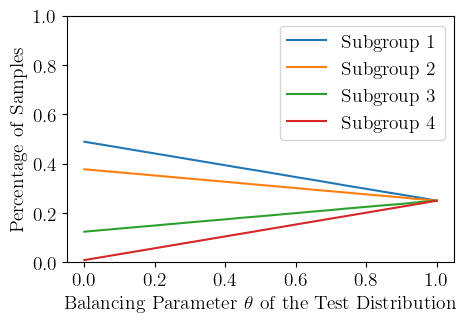

In [15]:
fig = plt.figure(figsize=(5.0,3.2))

for subgroup_id in np.unique(group_ids_test):
    counts = [np.sum(group_ids_test[indices] == subgroup_id) / len(indices) for indices in subset_indices_per_balancing_factor_test]
    plt.plot(balancing_factors, counts, label="Subgroup " + str(subgroup_id + 1))

    # Calculate intercept with the x-axis.
    lm = LinearRegression()
    lm.fit(balancing_factors.reshape(-1, 1), counts)
    slope = lm.coef_[0]
    intercept = lm.intercept_
    x_intercept = -intercept / slope
    print("x-intercept for subgroup " + str(subgroup_id + 1) + ": " + str(x_intercept))

plt.ylim(0,1)
plt.xlabel(r"Balancing Parameter $\theta$ of the Test Distribution")
plt.ylabel("Percentage of Samples")
plt.legend()

## 2. Training Classifier Heads for Hyperparameter Search

This section implements the training loop for the hyperparameter search.

**Key Difference from Main Experiment:**
-   We iterate through the list of candidate regularization strengths `C`.
-   For each `C`, we train a **single** classifier head.
-   This head is trained on a **fully balanced** dataset (`balancing_factor=1.0`), making it equivalent to a standard DFR model.

After training, we generate predictions for each model on the held-out validation set (`subset_train_score_mapping`).


In [16]:
# Reproducibility.
# We set the seed explicitly so that this cell is re-producible even when
# reexecuted (standalone reproducibility).
np.random.seed(seed)

# Train models and extract outputs.
tasks = {}
for base_model in base_models:
    print(
        "Generating reweighted DFR models and extracting model outputs for DFR models with feature backbone: "
        + str(base_model)
    )

    # Load corresponding ERM model.
    model = Model(root=root_dir, model=base_model, download=False).to(device)

    # Extract training and test features.
    # The resulting feature vectors have shape [n_samples, n_feature_dims].
    with torch.no_grad():
        feature_extractor = model.get_feature_extractor().eval()
        embeddings, labels = extract_features(
            feature_extractor=feature_extractor,
            dataloader=dataloader_train_dfr,
            extract_labels=True,
            device=device,
        )
        torch.cuda.empty_cache()
        X_train_dfr, y_train_dfr = [x.detach().cpu().numpy() for x in (embeddings, labels)]

        embeddings, labels = extract_features(
            feature_extractor=feature_extractor,
            dataloader=dataloader_train_score_mapping,
            extract_labels=True,
            device=device,
        )
        torch.cuda.empty_cache()
        X_train_score_mapping, y_train_score_mapping = [x.detach().cpu().numpy() for x in (embeddings, labels)]

    # Define and train DFR models.
    dfr_models = []
    for regularization_parameter_c in tqdm(
        regularization_parameters_c, desc="Train DFR models"
    ):
        # Select appropriate solver for the logistic regression.
        if len(subset_train_score_mapping.class_labels) == 2:
            clf = CustomLogisticRegression(
                num_retrains=20,
                balancing_factor=1.0,
                C=regularization_parameter_c,
                penalty="l1",
                solver="liblinear",
                random_state=seed,
                class_weight="balanced",
                # verbose=1,
            )
        else:
            warnings.warn("Multiclass problem, selecting different solver and penalty because this is not supported by liblinear!")
            clf = CustomLogisticRegression(
                num_retrains=20,
                balancing_factor=1.0,
                C=regularization_parameter_c,
                solver="lbfgs",
                n_jobs=-1,
                # penalty="l1",
                random_state=seed,
                class_weight="balanced",
                # verbose=1,
            )   

        dfr = DeepFeatureReweighting(classifier=clf)
        dfr_model = dfr._remove_shortcut(
            model=model,
            feature_extractor=feature_extractor,
            X=X_train_dfr,
            y=y_train_dfr,
            group_ids=group_ids_train_dfr,
            device=device,
        )
        dfr_models.append(dfr_model.to("cpu"))

    # Extract model predictions on the evaluation subset.
    outputs_train_score_mapping = []
    for model in tqdm(dfr_models, desc="Extract predicted probabilities for subset_train_score_mapping"):
        model = model.to(device)
        x = np.copy(X_train_score_mapping)

        # Preprocessing and classification.
        if model.preprocess:
            x = model.scaler.transform(x)
        x = model.classifier.predict_proba(x)
        outputs_train_score_mapping.append(x)
    outputs_train_score_mapping = np.array(outputs_train_score_mapping)

    if outputs_train_score_mapping.shape[2] == 2:
        # Binary problem.
        outputs_train_score_mapping = np.column_stack([x[:, 1] for x in outputs_train_score_mapping])
    else:
        # Multic-class problem.
        # Permute axes to [n_samples, n_regularization_parameters_c, n_classes].
        outputs_train_score_mapping = np.array(outputs_train_score_mapping).transpose((1, 0, 2))

        # Flatten the logits per balancing factor into a one-dimensional feature
        # vector.
        outputs_train_score_mapping = np.row_stack([x.flatten() for x in outputs_train_score_mapping])

    tasks[base_model] = {
        "X_train_dfr": X_train_dfr,
        "y_train_dfr": y_train_dfr,
        "X_train_score_mapping": X_train_score_mapping,
        "y_train_score_mapping": y_train_score_mapping,
        "outputs_train_score_mapping": outputs_train_score_mapping,
    }

print("Extracted model outputs of shape " + str(outputs_train_score_mapping.shape) + " for evaluating the DFR models.")

Generating reweighted DFR models and extracting model outputs for DFR models with feature backbone: izmailov_resnet50_erm_seed1


/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Train DFR models: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]
Extract predicted probabilities for subset_train_score_mapping: 100%|██████████| 24/24 [00:02<00:00,  8.11it/s]
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/blunk/anaconda3/envs/

Generating reweighted DFR models and extracting model outputs for DFR models with feature backbone: izmailov_resnet50_erm_seed2


Train DFR models: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s]
Extract predicted probabilities for subset_train_score_mapping: 100%|██████████| 24/24 [00:03<00:00,  7.82it/s]
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Generating reweighted DFR models and extracting model outputs for DFR models with feature backbone: izmailov_resnet50_erm_seed3


Train DFR models: 100%|██████████| 24/24 [00:20<00:00,  1.14it/s]
Extract predicted probabilities for subset_train_score_mapping: 100%|██████████| 24/24 [00:03<00:00,  7.37it/s]
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Generating reweighted DFR models and extracting model outputs for DFR models with feature backbone: izmailov_resnet50_erm_seed4


Train DFR models: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]
Extract predicted probabilities for subset_train_score_mapping: 100%|██████████| 24/24 [00:03<00:00,  7.48it/s]
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Generating reweighted DFR models and extracting model outputs for DFR models with feature backbone: izmailov_resnet50_erm_seed5


Train DFR models: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s]
Extract predicted probabilities for subset_train_score_mapping: 100%|██████████| 24/24 [00:03<00:00,  7.53it/s]

Extracted model outputs of shape (9934, 24) for evaluating the DFR models.


The following helper functions convert the raw probability outputs from the classifiers into class predictions, handling both binary and multi-class cases.

In [17]:
class FuncClassifier:
    def __init__(self, func, n_classes):
        self.func = func
        self.n_classes = n_classes
    
    def fit(self, X, y):
        pass

    def predict(self, X):
        # If binary, simply apply and check whether >= 0.
        # Otherwise, we first group by class labels and then apply to the
        # grouped variant. Afterwards, we predict via argmax.
        X = self.predict_proba(X)
        if self.n_classes == 2:
            return (X >= 0.5).astype(int)
        else:
            # Predict via argmax.
            return np.argmax(X, axis=1)
    
    def predict_proba(self, X):
        # For binary classification, we directly apply the function because the
        # data only contains a single logit per regularization parameter. For
        # multi-class classification, we first group by class labels and then
        # apply to the grouped variant. Afterwards, we predict via argmax.
        if self.n_classes == 2:
            return np.apply_along_axis(self.func, 1, X)
        else:
            # Reshape from [n_samples, n_regularization_parameters_c x n_classes] to 
            # [n_samples, n_regularization_parameters_c, n_classes]
            assert X.shape[1] % self.n_classes == 0, "The second data dimension is expected to be n_regularization_parameters_c x n_classes but your dimension is not divisible by the specified number of classes: shape " + str(X.shape) + " for n_classes " + str(self.n_classes)
            X = np.array(np.split(X, X.shape[1] // self.n_classes, axis=1))
            X = X.transpose((1,0,2))

            # Apply function.
            return np.apply_along_axis(self.func, 1, X)

In [18]:
def extract_predictions(X: np.ndarray, n_classes: int) -> np.ndarray:
    if n_classes == 2:
        # In the case of a binary problem, we only consider one logit (namely
        # that of class 1). Thus, we can perform a simple thresholding to
        # generate class predictions.
        predictions = (X >= 0.5).astype(int)
    else:
        # For multi-class problems, we use a small trick: The FuncClassifier
        # splits the one-dimensional feature vectors back into the outputs of
        # each individual classifier. Then, we only have to apply np.argmax to
        # the extracted probabilites.
        clf = FuncClassifier((lambda x: x), n_classes=n_classes)
        predictions = clf.predict_proba(X)
        predictions = np.argmax(predictions, axis=2)

    return predictions

In [19]:
# Generate predictions for the test dataset.
dfr_predictions = []
for i, base_model in enumerate(base_models):
    # Load features and targets.
    outputs_train_score_mapping, y_train_score_mapping = [tasks[base_model][z] for z in ["outputs_train_score_mapping", "y_train_score_mapping"]]

    # Generate predictions for all DFR models.
    p = extract_predictions(
        outputs_train_score_mapping, n_classes=len(subset_train_score_mapping.class_labels)
    )
    dfr_predictions.append(p)
dfr_predictions = np.array(
    dfr_predictions
)  # Shape: [n_base_models, n_samples, n_regularization_parameters_c]

## 3. Evaluation and Selection

We now evaluate the performance of each trained model on the held-out validation set (`subset_train_score_mapping`) and select the best `C`.

### 3.1. Baseline: ERM Performance

As a point of reference, we first evaluate the standard ERM model on the validation set. This shows the performance of a model with no post-hoc debiasing on this specific data split.

In [20]:
erm_predictions = []
for base_model in base_models:
    print(
        "Generating predictions for ERM model: "
        + str(base_model)
    )

    # Load corresponding ERM model.
    model = Model(root=root_dir, model=base_model, download=False).to(device)
    model = model.eval()

    # Conversion from model outputs to class label predictions.
    # We could also define this function once for all base models.
    if list(model.modules())[-1].out_features != 1:
        model_outputs_to_preds_transform = Lambda(lambda x: torch.argmax(x, dim=1))
    else:
        model_outputs_to_preds_transform = Lambda(lambda x: (x >= 0.5).long())

    # Extract predictions.
    with torch.no_grad():
        pred = torch.cat([model_outputs_to_preds_transform(model(x[0].to(device))).cpu()
                                    for x in tqdm(dataloader_train_score_mapping)])
        erm_predictions.append(pred)
del pred
model = model.to("cpu")
erm_predictions = np.array(erm_predictions)

/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Generating predictions for ERM model: izmailov_resnet50_erm_seed1


100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


Generating predictions for ERM model: izmailov_resnet50_erm_seed2


100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


Generating predictions for ERM model: izmailov_resnet50_erm_seed3


100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


Generating predictions for ERM model: izmailov_resnet50_erm_seed4


100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


Generating predictions for ERM model: izmailov_resnet50_erm_seed5


100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


In [21]:
erm_accuracies = np.array([accuracy_score(y_train_score_mapping, p) for p in erm_predictions])
erm_wsg_accuracies = np.array(
    [worst_subgroup_accuracy(y_train_score_mapping, p, group_ids_train_score_mapping) for p in erm_predictions]
)

print("ERM Statistics on Evaluation Subset:\n")
print("Accuracy (Avg):\t", np.mean(erm_accuracies))
print("Accuracy (Std):\t", np.std(erm_accuracies))
print("WSG (Avg):\t", np.mean(erm_wsg_accuracies))
print("WSG (Std):\t", np.std(erm_wsg_accuracies))

ERM Statistics on Evaluation Subset:

Accuracy (Avg):	 0.9519226897523657
Accuracy (Std):	 0.00158091165125029
WSG (Avg):	 0.4317073170731708
WSG (Std):	 0.05431965232029291


### 3.2. DFR Model Performance vs. Regularization Strength

We now compute the overall accuracy and worst-subgroup accuracy for each of the DFR models trained with different regularization strengths `C`.

In [22]:
dfr_accuracies = np.array(
    [
        [accuracy_score(y_train_score_mapping, p) for p in predictions.T]
        for predictions in dfr_predictions
    ]
)

# Worst Subgroup Accuracy.
dfr_wsg_accuracies = np.array(
    [
        [worst_subgroup_accuracy(y_train_score_mapping, p, group_ids_train_score_mapping) for p in predictions_per_regularization_parameter.T]
        for predictions_per_regularization_parameter in dfr_predictions
    ]
)

### 3.3. Results and Selection

The table below summarizes the performance for each value of `C`. Following the DFR methodology, we select the value of `C` that **maximizes the Worst-Group Accuracy**. This ensures the chosen model is robust and performs well even on the most challenging, bias-conflicting data subgroups. The best-performing value for each metric is highlighted in bold.

We display the results both as a markdown table as well as a TeX table (simplifying data export).

In [23]:
df = pd.DataFrame(
    {
        "Inverse Regularization Strength c" : regularization_parameters_c,
        "Accuracy (Avg)" : np.mean(dfr_accuracies, axis=0),
        "Accuracy (Std)" : np.std(dfr_accuracies, axis=0),
        "WSG (Avg)" : np.mean(dfr_wsg_accuracies, axis=0),
        "WSG (Std)" : np.std(dfr_wsg_accuracies, axis=0),
    }
)

print(dataset_name)
print(np.mean(dfr_wsg_accuracies, axis=0)) # Printing because this is the column we choose the hyperparameter on
print(display_df(df))

celeba
[0.77930546 0.77968384 0.78153002 0.78209817 0.78688099 0.79490686
 0.79849092 0.81645838 0.82664466 0.8252299  0.83239802 0.84381042
 0.84838481 0.85607168 0.86097618 0.86177788 0.85842962 0.83419005
 0.81834473 0.73218581 0.63815858 0.49455317 0.         0.        ]


,Inverse Regularization Strength c,Accuracy (Avg),Accuracy (Std),WSG (Avg),WSG (Std)
0,70000.000000,0.814355,0.002553,0.779305,0.005789
1,30000.000000,0.814657,0.002614,0.779684,0.005791
2,10000.000000,0.816227,0.002723,0.781530,0.006337
3,7000.000000,0.816831,0.002578,0.782098,0.006449
4,3000.000000,0.821321,0.003167,0.786881,0.007687
5,1000.000000,0.829515,0.003020,0.794907,0.007986
6,700.000000,0.833843,0.002809,0.798491,0.008421
7,300.000000,0.852406,0.003137,0.816458,0.008076
8,100.000000,0.862956,0.004522,0.826645,0.008175
9,70.000000,0.862432,0.005377,0.825230,0.009324


None


In [24]:
def format_significance(m, s, phantom_std=True):
    if phantom_std:
        return f"{m:>6.2%} ± {s:>{6}.2%}".replace(" ", "\\phantom{0}").replace("%", "")
    else:
        return f"{m:>6.2%} ± {s:>{5}.2%}".replace(" ", "\\phantom{0}").replace("%", "")

def scientific_notation(number, sig_fig=0):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return a + " * 10^" + str(b)

def scientific_notation(x, digits=0):
    enot = "{0:.{1:d}e}".format(x, digits)
    mantisse, exponent = enot.split("e")
    exponent = int(exponent)

    return mantisse + " \\cdot 10^{" + str(exponent) + "}"

print(scientific_notation(0.70))

# Find max values.
# We later need this to make the best values bold.
max_acc = df["Accuracy (Avg)"].max()
max_wsg = df["WSG (Avg)"].max()

# Export DataFrame to LaTeX.
df = pd.DataFrame(
    {
        # "Model": "DFR Model",
        # "Inverse Regularization Strength c": df["Inverse Regularization Strength c"].apply(lambda x: f"{x:>{9}.3f}".replace(" ", "\\phantom{0}")),
        "Inverse Regularization Strength c": df["Inverse Regularization Strength c"].apply(lambda x: "$" + scientific_notation(x) + "$"),
        "Accuracy (%, $\\uparrow$)": [format_significance(m, s, phantom_std=(df["Accuracy (Std)"] >= 0.1).any()) if m != max_acc else r"\textbf{" + format_significance(m, s, phantom_std=(df["Accuracy (Std)"] >= 0.1).any()) + "}" for m, s in zip(df["Accuracy (Avg)"], df["Accuracy (Std)"])],
        "Worst-Group Accuracy (%, $\\uparrow$)": [format_significance(m, s, phantom_std=(df["WSG (Std)"] >= 0.1).any()) if m != max_wsg else r"\textbf{" + format_significance(m, s, phantom_std=(df["WSG (Std)"] >= 0.1).any()) + "}" for m, s in zip(df["WSG (Avg)"], df["WSG (Std)"])],
    }
)
# raise ValueError("Invalid rounding of regularization strength.")
print(df.to_latex(index=False).replace("%", "\\%"))
with open(join(".", "outputs", dataset_name, dataset_name + " - Regularization Strength.tex"), "w") as f:
    f.write(df.to_latex(index=False).replace("%", "\\%"))

7 \cdot 10^{-1}
\begin{tabular}{lll}
\toprule
Inverse Regularization Strength c &                           Accuracy (\\%, \$\textbackslash uparrow\$) &               Worst-Group Accuracy (\\%, \$\textbackslash uparrow\$) \\
\midrule
                 \$7 \textbackslash cdot 10\textasciicircum \{4\}\$ &        81.44\textbackslash phantom\{0\}±\textbackslash phantom\{0\}\textbackslash phantom\{0\}0.26 &        77.93\textbackslash phantom\{0\}±\textbackslash phantom\{0\}\textbackslash phantom\{0\}0.58 \\
                 \$3 \textbackslash cdot 10\textasciicircum \{4\}\$ &        81.47\textbackslash phantom\{0\}±\textbackslash phantom\{0\}\textbackslash phantom\{0\}0.26 &        77.97\textbackslash phantom\{0\}±\textbackslash phantom\{0\}\textbackslash phantom\{0\}0.58 \\
                 \$1 \textbackslash cdot 10\textasciicircum \{4\}\$ &        81.62\textbackslash phantom\{0\}±\textbackslash phantom\{0\}\textbackslash phantom\{0\}0.27 &        78.15\textbackslash phantom\{0\}±\textback

/tmp/ipykernel_831926/3109001581.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False).replace("%", "\\%"))
/tmp/ipykernel_831926/3109001581.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df.to_latex(index=False).replace("%", "\\%"))


### 3.4. Visualization of Results

The plot below visualizes the performance metrics as a function of the inverse regularization strength `C` (on a log scale). This provides a clear view of the impact of regularization and helps confirm that the chosen value for `C` is in a stable and effective range.

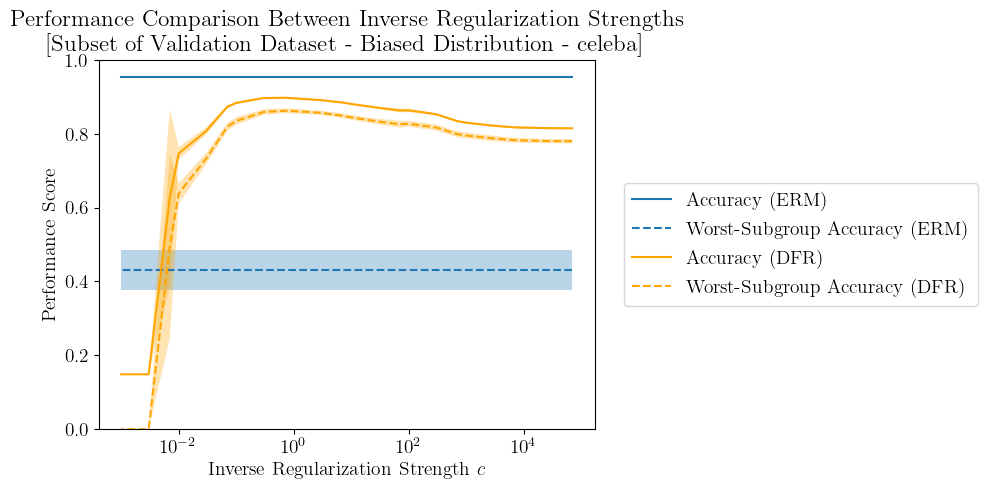

In [25]:
linestyle = {
    "Global Accuracy (Avg)": "solid",
    "Balanced Accuracy (Avg)": "dotted",
    "Worst Subgroup Accuracy (Avg)": "dashed"
}

# plt.figure(figsize=(10, 8))

# 1. ERM performance.
# Global Accuracy.
y = erm_accuracies
mean = np.mean(y).repeat(len(regularization_parameters_c))
std = np.std(y).repeat(len(regularization_parameters_c))
plt.plot(regularization_parameters_c, mean, label="Accuracy (ERM)", color="C0", linestyle=linestyle["Global Accuracy (Avg)"])
plt.fill_between(regularization_parameters_c, mean+std, mean-std, facecolor="C0", alpha=0.3)

# Worst Subgroup Accuracy.
y = erm_wsg_accuracies
mean = np.mean(y).repeat(len(regularization_parameters_c))
std = np.std(y).repeat(len(regularization_parameters_c))
plt.plot(regularization_parameters_c, mean, label="Worst-Subgroup Accuracy (ERM)", color="C0", linestyle=linestyle["Worst Subgroup Accuracy (Avg)"])
plt.fill_between(regularization_parameters_c, mean+std, mean-std, facecolor="C0", alpha=0.3)

# 2. DFR performance.
# Global Accuracy.
y = dfr_accuracies
mean = np.mean(y, axis=0)
std = np.std(y, axis=0)
plt.plot(regularization_parameters_c, mean, label="Accuracy (DFR)", color="orange", linestyle=linestyle["Global Accuracy (Avg)"])
plt.fill_between(regularization_parameters_c, mean+std, mean-std, facecolor="orange", alpha=0.3)

# Worst Subgroup Accuracy.
y = dfr_wsg_accuracies
mean = np.mean(y, axis=0)
std = np.std(y, axis=0)
plt.plot(regularization_parameters_c, mean, label="Worst-Subgroup Accuracy (DFR)", color="orange", linestyle=linestyle["Worst Subgroup Accuracy (Avg)"])
plt.fill_between(regularization_parameters_c, mean+std, mean-std, facecolor="orange", alpha=0.3)

plt.ylim(0., 1.)
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.xlabel(r"Inverse Regularization Strength $c$")
plt.ylabel("Performance Score")
plt.title("Performance Comparison Between Inverse Regularization Strengths\n[Subset of Validation Dataset - Biased Distribution - " + dataset_name + "]")
plt.show()